# Neural Network - multiclass classification

## Read the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        4560 non-null   object
 1   label       4560 non-null   int64 
 2   label_name  4560 non-null   object
dtypes: int64(1), object(2)
memory usage: 107.0+ KB


,text,label,label_name
0,The Organization of the Petroleum Exporting Co...,0,Business
1,American business tycoon Malcolm Glazer has in...,2,Sports
2,NEW YORK (Reuters) - International Business Ma...,1,SciTech
3,"Unilever, the world #39;s largest maker of foo...",0,Business
4,Australia #39;s Nathan Baggaley was over the m...,2,Sports


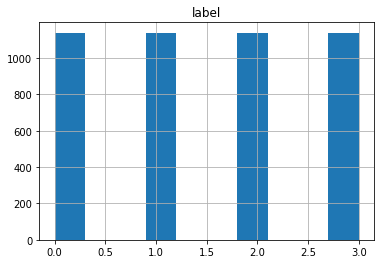

In [1]:
import pandas as pd

df_train = pd.read_json("../data/news_train.json", orient="records")
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1520 non-null   object
 1   label       1520 non-null   int64 
 2   label_name  1520 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.8+ KB


,text,label,label_name
0,The first hearing in the re-trial of former le...,3,World
1,Intel #39;s board has given the go ahead for t...,0,Business
2,Stocks closed higher on Wall Street as investo...,0,Business
3,Even with a boost from higher oil prices and g...,0,Business
4,Vornado Realty Trust said on Friday it has acq...,0,Business


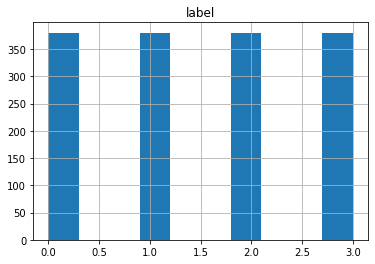

In [2]:
df_val = pd.read_json("../data/news_val.json", orient="records")
df_val.info()
df_val.hist()
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1520 non-null   object
 1   label       1520 non-null   int64 
 2   label_name  1520 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.8+ KB


,text,label,label_name
0,While rivals scramble to catch up on the deskt...,1,SciTech
1,AP - UCLA soccer coach Jillian Ellis was happy...,2,Sports
2,PCI Express allows Nvidia to tap into system m...,1,SciTech
3,AP - The Federal Election Commission on Thursd...,3,World
4,City officials hope there are people willing t...,1,SciTech


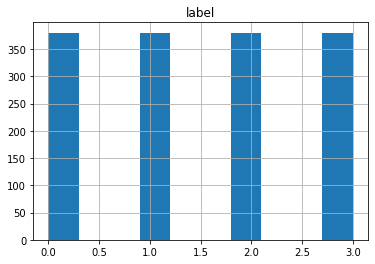

In [3]:
df_test = pd.read_json("../data/news_test.json", orient="records")
df_test.info()
df_test.hist()
df_test.head()

## Preprocessing data

In [ ]:
pip install nltk

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

STOPWORDS = stopwords.words("english")

def is_html_tag(word):
    w = word.replace("\n", "")
    return w.startswith("<") or w.startswith(">") or w.startswith("/") or w.strip()[:2] == "br"

def remove_html_tags(sentence):
    single_spaces = " ".join(sentence.split())

    return " ".join([token for token in single_spaces.split(" ") if not is_html_tag(token)])

def tokenize_sentence(sentence):
    return word_tokenize(sentence.lower())

def remove_stopwords(sentence):
    return " ".join([word for word in sentence.split(" ") if not word in STOPWORDS])

def remove_punctuation(tokenized_sentence):
    return [word for word in tokenized_sentence if word.isalpha()]

def preprocess(sentence):
    return remove_punctuation(tokenize_sentence(remove_stopwords(remove_html_tags(str(sentence)))))

print(preprocess(df_train["text"].values[1]))


['american', 'business', 'tycoon', 'malcolm', 'glazer', 'increased', 'stake', 'manchester', 'united', 'buying', 'another', 'worth', 'shares', 'club']


In [5]:
df_train["text"] = df_train["text"].apply(preprocess)
df_train.head()

,text,label,label_name
0,"[the, organization, petroleum, exporting, coun...",0,Business
1,"[american, business, tycoon, malcolm, glazer, ...",2,Sports
2,"[new, york, reuters, international, business, ...",1,SciTech
3,"[unilever, world, s, largest, maker, food, soa...",0,Business
4,"[australia, s, nathan, baggaley, moon, winning...",2,Sports


In [6]:
def build_vocab(tokenized_input, vocab_size):
    d = dict()

    for tokens in tokenized_input:
        for token in tokens:
            # double check
            if token not in STOPWORDS and token.isalpha():
                d[token] = d.get(token, 0) + 1

    del d["br"]

    return {k for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)[:vocab_size]}

In [7]:
VOCAB_SIZE = 10000
VOCAB = build_vocab(df_train["text"].values, VOCAB_SIZE) # (!) Always build the vocabulary on the TRAIN dataset

In [8]:
len(VOCAB)

10000

In [9]:
LABELS = df_train["label"].unique()
LABELS

array([0, 2, 1, 3], dtype=int64)

In [10]:
LABELS_TO_NAMES = {label: df_train[df_train["label"] == label].iloc[0]["label_name"] for label in LABELS}
LABELS_TO_NAMES

{0: 'Business', 2: 'Sports', 1: 'SciTech', 3: 'World'}

In [11]:
def get_frequencies_for_labels(df):
    dict_freqs = {label: {} for label in LABELS}

    for idx in range(df.shape[0]):
        tokens = df.iloc[idx, 0]
        label = df.iloc[idx, 1]
        
        for token in tokens:
            if token in VOCAB:
                dict_freqs[label][token] = dict_freqs[label].get(token, 0) + 1
            

    return dict_freqs

In [12]:
frequency_table = get_frequencies_for_labels(df_train)
frequency_table[0]["money"]

9

In [13]:
import numpy as np

def extract_features(frequency_table, tweet_tokens):
    label_frequencies = {label: 0 for label in LABELS}

    for t in tweet_tokens:
        for label in LABELS:
            label_frequencies[label] += frequency_table[label].get(t, 0)
    
    return pd.Series(label_frequencies)

In [14]:
X_train = df_train["text"].apply(lambda tokens: extract_features(frequency_table, tokens))
X_train

,0,2,1,3
0,598,192,199,205
1,232,239,100,143
2,1313,824,889,962
3,449,133,208,80
4,176,557,144,188
...,...,...,...,...
4555,76,12,19,9
4556,711,432,329,736
4557,158,824,172,282
4558,316,175,181,222


In [15]:
y_train = df_train["label"].values
y_train

array([0, 2, 1, ..., 2, 0, 3], dtype=int64)

In [16]:
X_val = df_val["text"].apply(preprocess)
X_val = df_val["text"].apply(lambda tokens: extract_features(frequency_table, tokens))
y_val = df_val["label"].values
X_val

,0,2,1,3
0,78,64,50,33
1,80,69,79,33
2,52,50,55,23
3,55,43,83,25
4,46,36,47,18
...,...,...,...,...
1515,82,60,53,33
1516,56,42,32,19
1517,65,42,88,16
1518,49,33,48,13


## Create model and train / validate

In [ ]:
pip install tensorflow

In [17]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(units=4, activation='softmax')
])

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
              
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 9,156
Trainable params: 9,156
Non-trainable params: 0
_________________________________________________________________


In [18]:
h = model.fit(X_train,
              y_train,
              epochs=10,
              batch_size=32,
              validation_data=(X_val, y_val))

Epoch 1/10
143/143 [==============================] - 3s 17ms/step - loss: 11.2097 - accuracy: 0.6999 - val_loss: 5.0274 - val_accuracy: 0.2507
Epoch 2/10
143/143 [==============================] - 0s 3ms/step - loss: 4.7159 - accuracy: 0.7475 - val_loss: 4.9074 - val_accuracy: 0.2743
Epoch 3/10
143/143 [==============================] - 0s 3ms/step - loss: 4.0378 - accuracy: 0.7517 - val_loss: 3.8153 - val_accuracy: 0.2493
Epoch 4/10
143/143 [==============================] - 0s 2ms/step - loss: 3.6744 - accuracy: 0.7435 - val_loss: 6.1908 - val_accuracy: 0.2750
Epoch 5/10
143/143 [==============================] - 0s 2ms/step - loss: 4.5968 - accuracy: 0.7400 - val_loss: 2.9743 - val_accuracy: 0.2520
Epoch 6/10
143/143 [==============================] - 0s 2ms/step - loss: 3.3249 - accuracy: 0.7456 - val_loss: 5.2280 - val_accuracy: 0.2678
Epoch 7/10
143/143 [==============================] - 0s 2ms/step - loss: 3.2745 - accuracy: 0.7510 - val_loss: 2.8505 - val_accuracy: 0.2553
Epoc

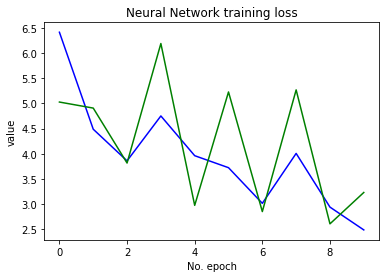

In [19]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='(training data)',color='blue')
plt.plot(h.history['val_loss'], label='(validation data)',color='green')
plt.title('Neural Network training loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

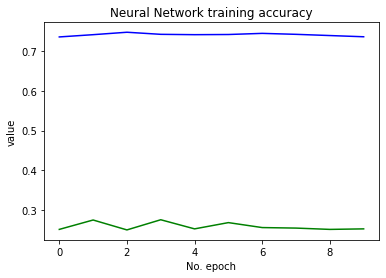

In [20]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'], label='(training data)',color='blue')
plt.plot(h.history['val_accuracy'], label='(validation data)',color='green')
plt.title('Neural Network training accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

## Evaluate the trained model

In [21]:
X_test = df_test["text"].apply(preprocess)
X_test = df_test["text"].apply(lambda tokens: extract_features(frequency_table, tokens))
y_test = df_test["label"].values
X_test

,0,2,1,3
0,56,55,95,20
1,69,64,112,32
2,54,48,109,24
3,66,62,81,32
4,96,83,129,43
...,...,...,...,...
1515,96,61,168,30
1516,83,58,73,27
1517,86,64,126,31
1518,40,28,40,25


In [22]:
results = model.evaluate(X_test, y_test, batch_size=50)
print("test loss, test acc:", results)

31/31 [==============================] - 0s 2ms/step - loss: 3.1699 - accuracy: 0.2553
test loss, test acc: [3.1699059009552, 0.25526314973831177]


In [23]:
df_test_raw = pd.read_json("../data/news_test.json", orient="records")

In [24]:
predictions = np.round(model.predict(X_test[:100]))
for i in range(len(predictions)):
    print(df_test_raw["text"].values[i][:100],"...")
    print("Pred: ", predictions[i], "Real: ", y_test[i])

While rivals scramble to catch up on the desktop, Google plans to digitize famous libraries. Its off ...
Pred:  [0. 1. 0. 0.] Real:  1
AP - UCLA soccer coach Jillian Ellis was happy to beat her best friend, Princeton counterpart Julie  ...
Pred:  [0. 1. 0. 0.] Real:  2
PCI Express allows Nvidia to tap into system memory to save expensive on-board graphics memory and a ...
Pred:  [0. 1. 0. 0.] Real:  1
AP - The Federal Election Commission on Thursday elected a new chairman and vice chairman, choosing  ...
Pred:  [0. 1. 0. 0.] Real:  3
City officials hope there are people willing to pay plenty of money to own a vintage Playboy Bunny c ...
Pred:  [0. 1. 0. 0.] Real:  1
KIEV (Reuters) - Ukrainian Prime Minister Viktor Yanukovich  said on Saturday he would stand against ...
Pred:  [1. 0. 0. 0.] Real:  3
AFP - French auto giant Renault SA said it will invest some 570 million dollars in South Korea over  ...
Pred:  [0. 1. 0. 0.] Real:  3
Buffalo Bills offensive coordinator Tom Clements has em